<a href="https://colab.research.google.com/github/sexymetra/Ai-project/blob/LeeSangHyuck/gru%EB%A5%BC_%ED%99%9C%EC%9A%A9%ED%95%9C_%EB%B2%84%EC%A0%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Hyperparameter Setting
이부분만 변경시키면 됨


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#하이퍼 파라미터
hyperparam = {
    'epoch':50,
    'learning_rate':1e-3,
    'batch_size':32,
    'num_layers': 2 # model parameter
}
constant = {
    'day_to_predict': 2, # 예측해야 하는 day의 수
    'total_day' : 200
}

# interval-5, interval-10, interval-20 중 하나 고르셈
data_directory_name = "interval-10/"

# 기록할 때 쓸꺼임
model_name = "main_gru"

## Colab drive mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 데이터 불러오기

In [ ]:
Path = "/content/drive/MyDrive/Colab Notebooks/2022 Inha challenge/data/"
train_data = np.load(Path+data_directory_name+"train_data.npy")
train_labels = np.load(Path+data_directory_name+"train_labels.npy")
validation_data = np.load(Path+data_directory_name+"validation_data.npy")
validation_labels = np.load(Path+data_directory_name+"validation_labels.npy")

## 현재 모델 저장용 directory 생성

In [ ]:
import datetime
import os

serial = f"{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"
directory = f"/content/drive/MyDrive/Colab Notebooks/2022 Inha challenge/model/{serial}"
os.makedirs(directory)

## 하이퍼 파라미터 기록

In [ ]:
with open(directory+"/model_info.txt", "w") as file:
    # model name
    file.write("Model\n")
    file.write(f"model file name : {model_name}\n")
    file.write("\n")

    # data
    file.write("Used data\n")
    file.write(f"data directory : {data_directory_name}\n")
    file.write(f"data path : {Path+data_directory_name}\n")
    file.write("\n")
    # hyperparam
    file.write("hyperparam\n")
    file.write(f"learning_rate : {hyperparam['learning_rate']}\n")
    file.write(f"batch_size : {hyperparam['batch_size']}\n")
    file.write(f"num_layers : {hyperparam['num_layers']}\n")
    file.write("\n")
    

## TensorBoard
https://medium.com/looka-engineering/how-to-use-tensorboard-with-pytorch-in-google-colab-1f76a938bc34
https://pytorch.org/docs/stable/tensorboard.html

In [ ]:
%load_ext tensorboard
from torch.utils.tensorboard import SummaryWriter

log_dir = directory+"/graph"
writer = SummaryWriter(log_dir)

## Custom Dataset

In [ ]:
class CustomDataset:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, ind):
        return torch.Tensor(self.data[ind]), torch.Tensor(self.labels[ind])

## DataLoader setting

In [ ]:
train_dataset = CustomDataset(train_data, train_labels)
validation_dataset = CustomDataset(validation_data, validation_labels)
train_loader = DataLoader(train_dataset, batch_size = hyperparam['batch_size'], shuffle=True)

train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = hyperparam["batch_size"],
    shuffle = True
)
test_loader = DataLoader(
    dataset = validation_dataset,
    batch_size = hyperparam["batch_size"],
    shuffle = False
)

## 모델 선언

In [ ]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.gru = nn.GRU(input_size=8, hidden_size=256, num_layers = hyperparam['num_layers'], batch_first=True, bidirectional=False)
        self.classifier = nn.Sequential(
            nn.Linear(256,516),
            nn.ReLU(),
            nn.Linear(516,288),
            nn.ReLU()
        )
        
    def forward(self, x):
        hidden, _ = self.gru(x)
        output = self.classifier(hidden[:,-1,:])
        return output

# 평가 함수

## Customize loss function
https://neptune.ai/blog/pytorch-loss-functions

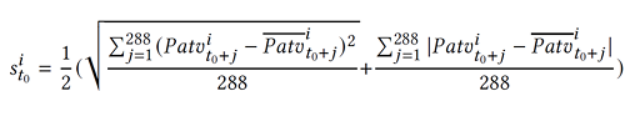

In [ ]:
def lossfunction(input, target, day = 2):
    return (torch.sqrt(torch.sum((input - target)**2)/(day*144)) + torch.sum(torch.abs(input - target))/(day*144))/2

## 모델 테스트

In [ ]:
def test(epoch):
    model.eval() # nn.Module.eval method, train 과 test 를 구분, train 할 때는 model.train 을 호출한다
    score = 0
    maxval = 0
    minval = 1e9
    for data, target in test_loader:
        data, target = data.to(device), target.to(device) # gpu 에 tensor 들을 할당함(cpu가 아닌 gpu 로 계산하기 위함), 여기서 data, target 은 tensor 이다
        output = model(data)

        cur = lossfunction(output, target)
        score += cur
        maxval = max(maxval, cur)
        minval = min(minval, cur)

    score /= len(test_loader)

    # Tensorboard
    #writer.add_scalar('Loss/test', score, epoch)

    print("="*44)
    print(f"Test set: socore : {score:.4f}")
    print(f"        : max    : {maxval:.4f}")
    print(f"        : min    : {minval:.4f}")
    return score

## 모델 학습

In [ ]:
def train():
    model.to(device)
    for epoch in range(1, hyperparam['epoch']+1):
        model.train()
        train_loss = []
        for X, Y in tqdm(iter(train_loader)):
            X = X.to(device)
            Y = Y.to(device)
            
            optimizer.zero_grad()
            
            output = model(X)
            loss = lossfunction(output, Y)
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
        
        train_loss = np.mean(train_loss)
        print(f'Epoch : [{epoch}] Train Loss : [{train_loss:.5f}]')
        test_loss = test(epoch)

        # Tensorboard
        #writer.add_scalar('Loss/train', loss, epoch)
        writer.add_scalars('Loss', {'test':test_loss,
                                    'train':train_loss}
                           , epoch)

        torch.save(model.state_dict(), directory+f"/{epoch}.pth", _use_new_zipfile_serialization=False)
        print('Model Saved.')

### 모델 학습

In [ ]:
model = BaseModel()
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = hyperparam["learning_rate"])
train()

100%|██████████| 569/569 [01:08<00:00,  8.26it/s]


Epoch : [1] Train Loss : [4763.82471]
Test set: socore : 6102.0171
        : max    : 7910.0322
        : min    : 1269.4648
Model Saved.


100%|██████████| 569/569 [01:07<00:00,  8.37it/s]


Epoch : [2] Train Loss : [4352.38477]


RuntimeError: ignored

In [ ]:
# path 에 띄어쓰기 있는 경우 magic command 에서 path로 인식이 안됨. " " -> "\ "
log_dir = log_dir.replace(" ", "\\ ")

In [ ]:
writer.flush()
writer.close()

%tensorboard --logdir=$log_dir